In [ ]:
# This is a notebook to test the stage calibration. It is based on the example script testStageCalibration.py. The notebook is used to test the stage calibration and to visualize the results.

In [ ]:
#%%
import imswitchclient.ImSwitchClient as imc 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from skimage.registration import phase_cross_correlation

stageName=None
scanMax=100
scanMin=-100
scanStep = 50
rescalingFac=10.0
gridScan=True
pixelSize = 1.0

# Instantiate the ImSwitchClient
client = imc.ImSwitchClient()


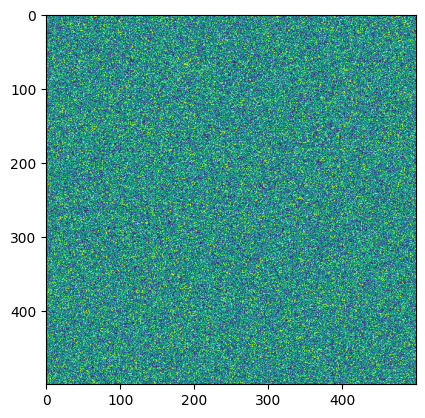

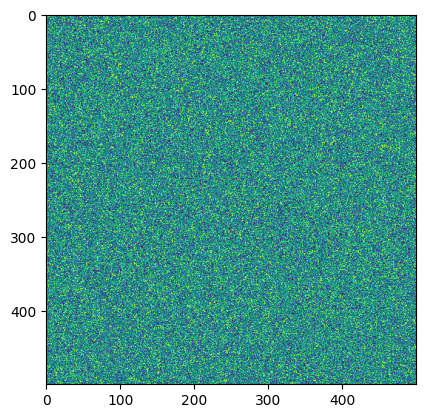

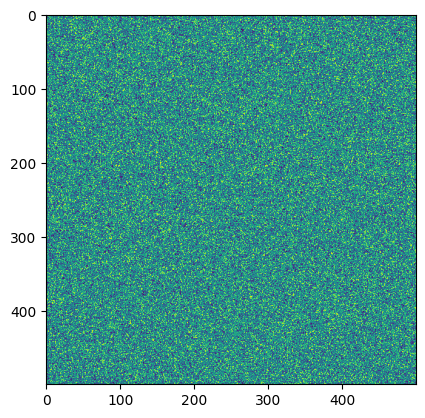

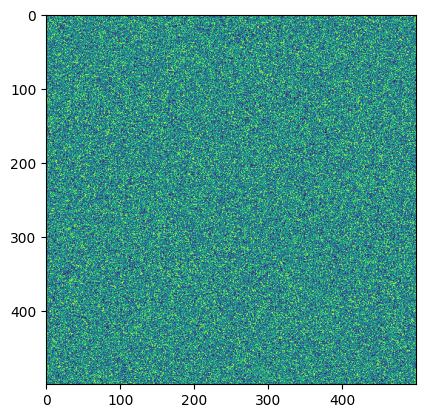

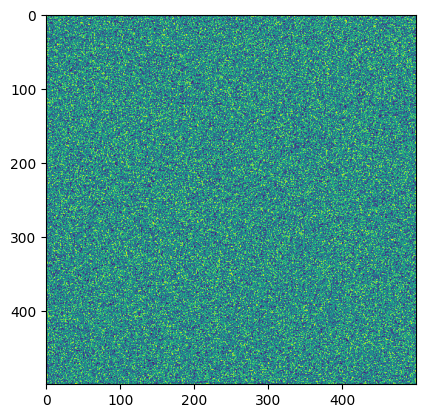

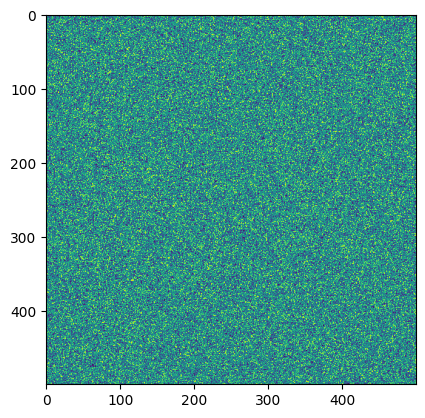

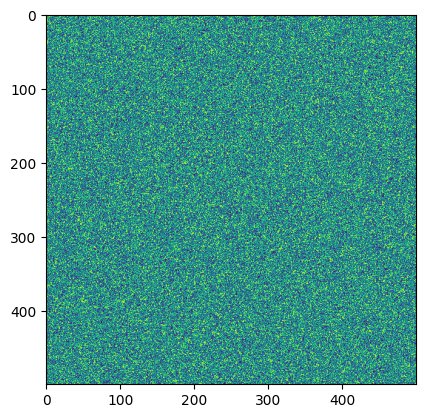

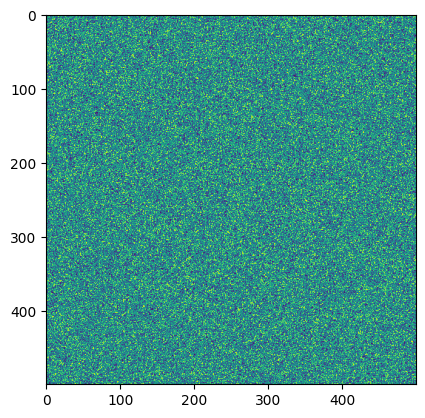

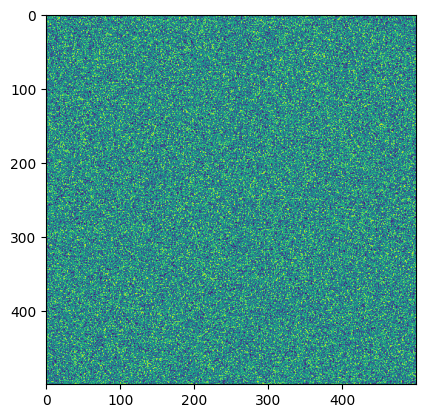

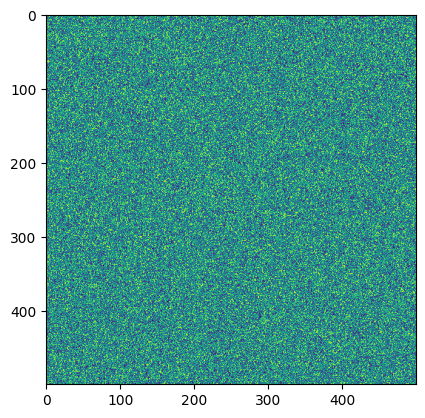

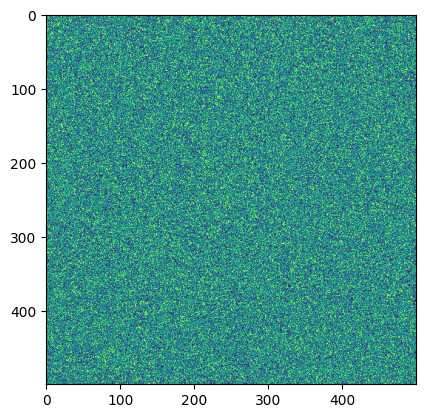

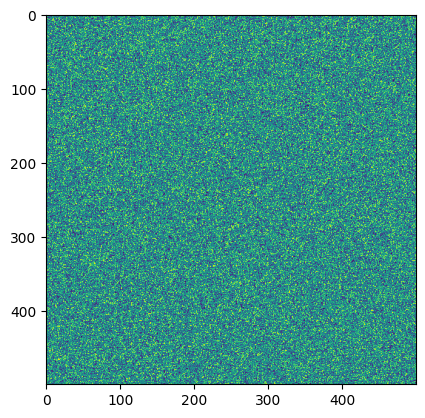

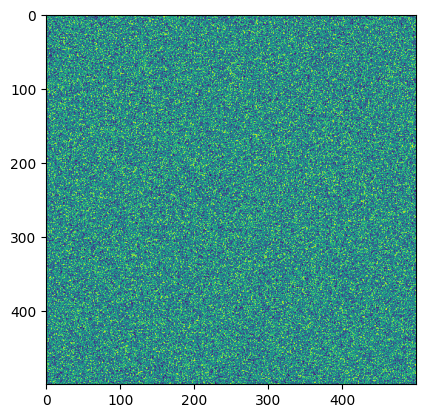

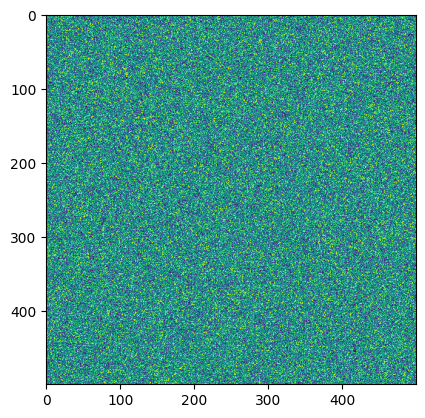

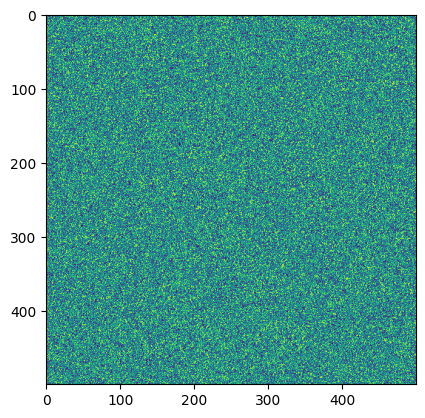

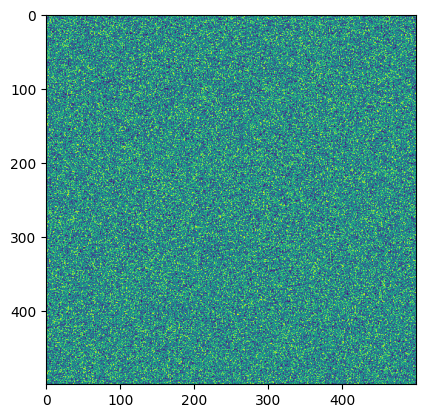

In [4]:
#%%
# Test the get_positioner_names method
positioner_names = client.positionersManager.getAllDeviceNames()
positioner_name = positioner_names[0]

currentPositions = client.positionersManager.getPositionerPositions()[positioner_name]
initialPosition = (currentPositions["X"], currentPositions["Y"])
initialPosiionZ = currentPositions["Z"]

scanMin = -100
scanMax = 100
scanStep = 50

# snake scan
if gridScan:
    xyScanStepsAbsolute = []
    fwdpath = np.arange(scanMin, scanMax, scanStep)
    bwdpath = np.flip(fwdpath)
    for indexX, ix in enumerate(np.arange(scanMin, scanMax, scanStep)): 
        if indexX%2==0:
            for indexY, iy in enumerate(fwdpath):
                xyScanStepsAbsolute.append([ix, iy])
        else:
            for indexY, iy in enumerate(bwdpath):
                xyScanStepsAbsolute.append([ix, iy])
    xyScanStepsAbsolute = np.array(xyScanStepsAbsolute)    
else:
    # avoid grid pattern to be detected as same locations => random positions
    xyScanStepsAbsolute = np.random.randint(scanMin, scanMax, (10,2))

#%%
# initialize xy coordinates
value = xyScanStepsAbsolute[0,0] + initialPosition[0], xyScanStepsAbsolute[0,1] + initialPosition[1]
client.positionersManager.movePositioner(positioner_name, "X", value[0], is_absolute=True, is_blocking=True)
client.positionersManager.movePositioner(positioner_name, "Y", value[1], is_absolute=True, is_blocking=True)

# store images
allPosImages = []
for ipos, iXYPos in enumerate(xyScanStepsAbsolute):
    
    # move to xy position is necessary
    value = iXYPos[0]+initialPosition[0],iXYPos[1]+initialPosition[1]
    client.positionersManager.movePositioner(positioner_name, "X", value[0], is_absolute=True, is_blocking=True)
    client.positionersManager.movePositioner(positioner_name, "Y", value[1], is_absolute=True, is_blocking=True)

    #TODO: do we move to the correct positions?
    # antishake
    time.sleep(0.5)
    lastFrame = client.recordingManager.snapNumpyToFastAPI()
    allPosImages.append(lastFrame)
    plt.imshow(lastFrame), plt.show()

# reinitialize xy coordinates
value = initialPosition[0], initialPosition[1]
client.positionersManager.movePositioner(positioner_name, "X", value[0], is_absolute=True, is_blocking=True)
client.positionersManager.movePositioner(positioner_name, "Y", value[1], is_absolute=True, is_blocking=True)


In [5]:

# process the slices and compute their relative distances in pixels
# compute shift between images relative to zeroth image
print("Starting to compute relative displacements from the first image")
allShiftsComputed = []
for iImage in range(len(allPosImages)):
    image1 = allPosImages[0] 
    image2 = allPosImages[iImage]
    
    if len(image1.shape)>2:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # downscaling will reduce accuracy, but will speed up computation
    image1 = cv2.resize(image1, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)
    image2 = cv2.resize(image2, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)

    shift, error, diffphase = phase_cross_correlation(image1, image2)
    shift *=rescalingFac
    print("Shift w.r.t. 0 is:"+str(shift))
    allShiftsComputed.append((shift[0],shift[1]))
    
# compute averrage shifts according to scan grid 
# compare measured shift with shift given by the array of random coordinats
allShiftsPlanned = np.array(xyScanStepsAbsolute)
allShiftsPlanned -= np.min(allShiftsPlanned,0)
allShiftsComputed = np.array(allShiftsComputed)

# compute differencs
nShift = (scanMax-scanMin)//scanStep


# determine the axis and swap if necessary (e.g. swap axis (y,x))
dReal = np.abs(allShiftsPlanned-np.roll(allShiftsPlanned,-1,0))
dMeasured = np.abs(allShiftsComputed-np.roll(allShiftsComputed,-1,0))
xAxisReal = np.argmin(np.mean(dReal,0))
xAxisMeasured = np.argmin(np.mean(dMeasured,0))
if xAxisReal != xAxisMeasured:
    xAxisMeasured = np.transpose(xAxisMeasured, (1,0))

# stepsize => real motion / stepsize 
stepSizeStage = (dMeasured*pixelSize)/dReal
stepSizeStage[stepSizeStage == np.inf] = 0
stepSizeStage = np.nan_to_num(stepSizeStage, nan=0.)
stepSizeStage = stepSizeStage[np.where(stepSizeStage>0)]
stepSizeStageDim = np.mean(stepSizeStage)
stepSizeStageVar = np.var(stepSizeStage)






Starting to compute relative displacements from the first image
Shift w.r.t. 0 is:[0. 0.]
Shift w.r.t. 0 is:[ 210. -130.]
Shift w.r.t. 0 is:[ 80. 200.]
Shift w.r.t. 0 is:[ -20. -210.]
Shift w.r.t. 0 is:[ 200. -210.]
Shift w.r.t. 0 is:[ 140. -130.]
Shift w.r.t. 0 is:[-20. 200.]
Shift w.r.t. 0 is:[240. 150.]
Shift w.r.t. 0 is:[ 50. -40.]
Shift w.r.t. 0 is:[-220. -130.]
Shift w.r.t. 0 is:[210. -50.]
Shift w.r.t. 0 is:[100.  80.]
Shift w.r.t. 0 is:[230. 130.]
Shift w.r.t. 0 is:[240. -90.]
Shift w.r.t. 0 is:[-70. 120.]
Shift w.r.t. 0 is:[-50.  60.]


ValueError: axes don't match array